In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm

## Direct Monte-Carlo Estimation

In MC estimation, we approximate an integral by the sample mean of a function of simulated random variables. In more mathematical terms,

$$\int p(x)\ f(x)\ dx = \mathbb{E}_{p(x)} \big[\ f(x) \big] \approx \frac{1}{N} \sum_{n=1}^{N}f(x_n)$$

where $x_n \sim \ p(x)$.

A useful application of MC is probability estimation. In fact, we can cast a probability as an expectation using the indicator function. In our case, given that $A = \{I \ | \ I > 2.5\}$, we define $f(x)$ as

$$f(x) = I_{A}(x)= \begin{cases} 
      1 & I \geq 2.5 \\
      0 & I < 2.5 
   \end{cases}$$
   
Replacing in our equation above, we get

$$\int p(x) \ f(x) \ dx = \int I(x)\ p(x) \ d(x) = \int_{x \in A} p(x)\ d(x) \approx \frac{1}{N} \sum_{n=1}^{N}I_{A}(x_n)$$

In [2]:
'create a distribution we can easily sample from' 
q = lambda x: norm.pdf(x, 0, 4)
x = np.linspace(-10,10,100)
y_q = q(x)

In [3]:
'generate simulations via direct monte-carlo estimation'
iterations = int(1e3)
average = []
samples = []
prob = []

for i in range(iterations):
    samples.append(np.random.normal(0, 4))
    average.append(np.mean(samples))
    prob.append(np.sum(np.array(samples) > 2.5) / (i+1))
    
average = np.array(average)
samples = np.array(samples)
prob = np.array(prob)

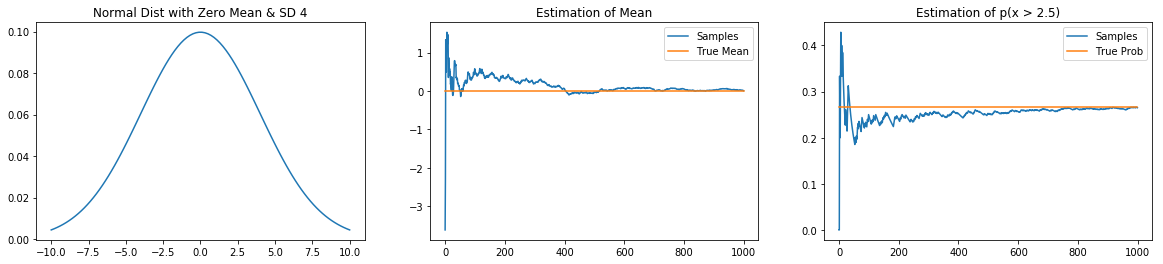

In [4]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(x, y_q)
plt.title("Normal Dist with Zero Mean & SD 4")

plt.subplot(132)
plt.plot(average, label='Samples')
plt.plot(np.ones(iterations) * 0, label="True Mean")
plt.title("Estimation of Mean")
plt.legend()

plt.subplot(133)
plt.plot(prob, label='Samples')
plt.plot(np.ones(iterations) * norm.sf(2.5, 0, 4), label='True Prob')
plt.title("Estimation of p(x > 2.5)")
plt.legend()
plt.show()

In [14]:
print("Sample Mean and SD:, ", np.round(average[-1],2), "|" ,np.round(np.std(samples), 2))
print("Estimation of P(x > 2.5): ", np.round(prob[-1],2))

Sample Mean and SD:,  0.01 | 4.1
Estimation of P(x > 2.5):  0.26


## Setup - Rejection and Importance Sampling
Often we are unable to directly sample from a distribution, here we look at two methods which use a simple distribution (such as the normal distribution used above) to sample from a more complex distribution. 

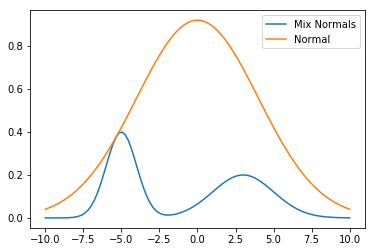

In [15]:
'create a complex distribution as a mixture of two normals & calculate y values'
p = lambda x : norm.pdf(x, 3, 2) + norm.pdf(x, -5, 1)
y_p = p(x)

'Determine the maximum - used to scale q for rejection sampling (ensures ratio is always between 0 and 1, i.e. uniform)'
c = np.max(p(x)/q(x))

'plot distributions'
plt.plot(x, y_p, label="Mix Normals")
plt.plot(x, c*y_q, label="Normal")
plt.legend()
plt.show()

### Rejection Sampling
One method for generating observations from the mixture of normals is rejection sampling. Here we generate a sample from the simple normal distribution and accept the sample based on some random uniform threshold. The algorithm is as follows:

1. Sample $x'\sim q(x)$
2. Sample $u \sim U(0,1)$
3. Accept $x'$ if $u < \dfrac{p(x')}{c q(x')}$

In [16]:
'generate simulations from p using rejection sampling'
iterations = int(1e3)
accepted = []
samples = []
average = []

for i in range(iterations):
    sample = np.random.normal(0,4)
    u = np.random.uniform()
    samples.append(sample)
    if u < p(sample) / (c*q(sample)):
        accepted.append(sample)
        average.append(np.mean(accepted))
        
accepted = np.array(accepted)
samples = np.sort(samples)
average = np.array(average)

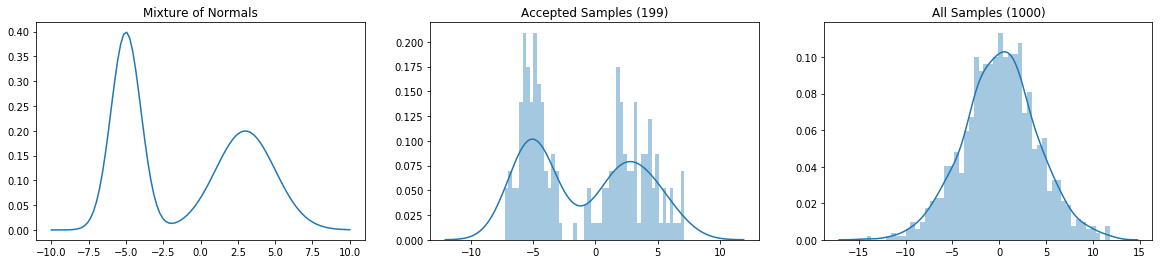

In [17]:
plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.plot(x, y_p)
plt.title("Mixture of Normals")

plt.subplot(132)
sns.distplot(accepted, bins=50)
plt.title("Accepted Samples ({})".format(len(accepted)))

plt.subplot(133)
sns.distplot(samples, bins=50)
plt.title("All Samples ({})".format(len(samples)))
plt.show()

In [18]:
print("Sample Mean and SD: ", np.round(average[-1],2), "|" ,np.round(np.std(samples), 2))
print("Std for expectation across iterations: ", np.round(np.std(average),2))

Sample Mean and SD:  -0.94 | 3.95
Std for expectation across iterations:  0.55


### Importance Sampling (Approximation)
Rejection sampling can be very wasteful if the target distribution is significantly smaller than the simple distribution sampled from. For example, in the above experiment we generate 1000 samples but only keep approx 200-250. With importance sampling we continue to generate samples from the simple distribution but instead reweight them according to their importance. 

Concretely,

$$\mathbb{E}_{p(x)} \big[\ f(x) \big] = \int f(x)\ p(x)\ dx = \int f(x)\ p(x)\ \frac{q(x)}{q(x)}\ dx = \int \frac{p(x)}{q(x)}\cdot f(x)\ q(x)\ dx = \mathbb{E}_{q(x)}  \big[\ f(x)\cdot \frac{p(x)}{q(x)} \big]$$

Thus, the MC estimation of the expectation becomes:

$$\mathbb{E}_{q(x)}  \big[\ f(x)\cdot \frac{p(x)}{q(x)} \big] \approx \frac{1}{N} \sum_{n=1}^{N} w_n \cdot f(x_n)$$

where $w_n = \dfrac{p(x_n)}{q(x_n)}$. Unlike rejection sampling we make use of all samples in calculating the expectation, thus reducing the variance of the estimator. 

In [19]:
'generate importance samples and weights'
iterations = int(1e3)
w = []
samples = []
average = []

for i in range(iterations):
    sample = np.random.normal(0, 4)
    samples.append(sample)
    w.append(p(sample) / (q(sample)))
    average.append(np.average(samples, weights=w))

w = np.array(w)
samples = np.array(samples)
average = np.array(average)

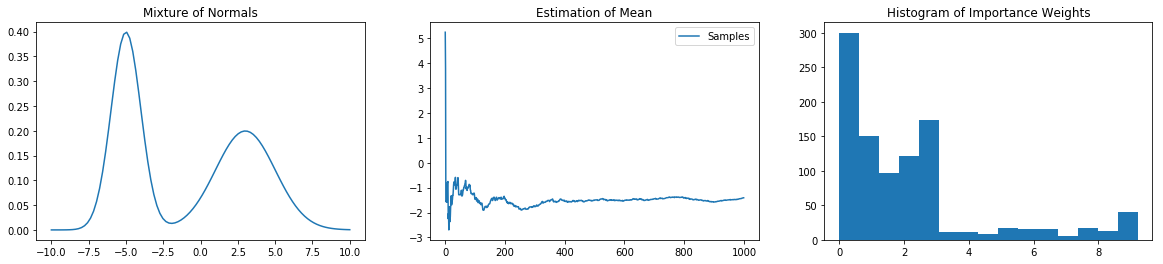

In [20]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(x, y_p)
plt.title("Mixture of Normals")

plt.subplot(132)
plt.plot(average, label='Samples') # plot calculation of average 
plt.title("Estimation of Mean")
plt.legend()

plt.subplot(133)
plt.hist(w, bins=15)
plt.title("Histogram of Importance Weights")
plt.show()

In [21]:
print("Sample Mean and SD: ", np.round(average[-1],2), "|" ,np.round(np.std(samples), 2))
print("Std for expectation across iterations: ", np.round(np.std(average),2))

Sample Mean and SD:  -1.41 | 4.1
Std for expectation across iterations:  0.33
